In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sklearn as sk
import seaborn as sns

## preprocessing

In [66]:
raw_data = scp.io.arff.loadarff('data/EEG Eye State.arff')
df = pd.DataFrame(raw_data[0])
df['eyeDetection'] = df['eyeDetection'].apply(lambda x: int(x.decode()))

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, test_size=0.2)

smooth_scaler = sk.preprocessing.StandardScaler()
X_train_scaled, X_test_scaled = smooth_scaler.fit_transform(X_train), smooth_scaler.transform(X_test)

Check for y distribution. Balanced due to stratification

In [84]:
unique_train, train_counts = np.unique(y_train, return_counts=True)
unique_test, test_counts = np.unique(y_test, return_counts=True)
print(f'Train label distribution: {dict(zip(unique_train, train_counts))}')
print(f'Test label distribution: {dict(zip(unique_test, test_counts))}')

Train label distribution: {0: 6606, 1: 5378}
Test label distribution: {0: 1651, 1: 1345}


## initial visualisation

## PCA

In [67]:
init_pca = sk.decomposition.PCA(n_components=14)
init_pca_fit = init_pca.fit(X_train_scaled)

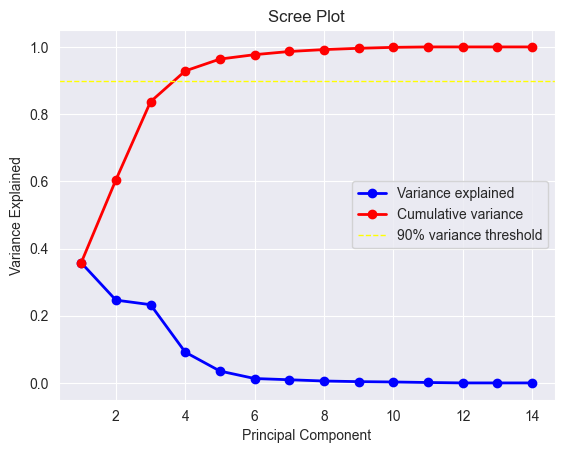

In [68]:
init_PC_values = np.arange(init_pca.n_components_) + 1
init_variance = np.cumsum(init_pca.explained_variance_ratio_)

plt.plot(init_PC_values, init_pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue', label='Variance explained')
plt.plot(init_PC_values, init_variance, 'o-', linewidth=2, color='red', label='Cumulative variance')
plt.axhline(y=0.9, color='yellow', linestyle='--', linewidth=1, label='90% variance threshold')

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

plt.legend()
plt.show()

The drop in the scree plot is at PC4. the first 4 components account for 91.5% of the total variance. Therefore, I will only use the first four to look for clusters/patterns.

In [69]:
pca = sk.decomposition.PCA(n_components=4)
X_pca = pca.fit(X_train_scaled)

X_pca_train = pca.transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

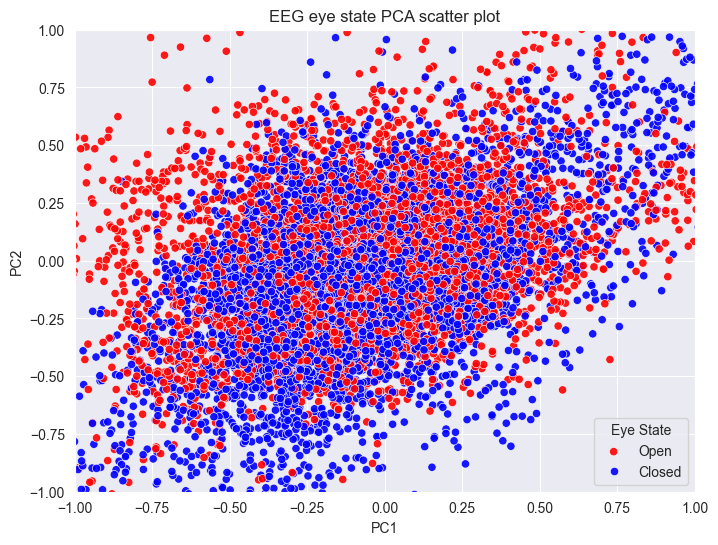

In [70]:
pca_df = pd.DataFrame(X_pca_train, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['eyeDetection'] = y_train

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='eyeDetection',
    palette={0:'blue', 1:'red'},
    alpha=0.9
)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('EEG eye state PCA scatter plot')
plt.legend(title='Eye State', labels=['Open', 'Closed'])
plt.show()

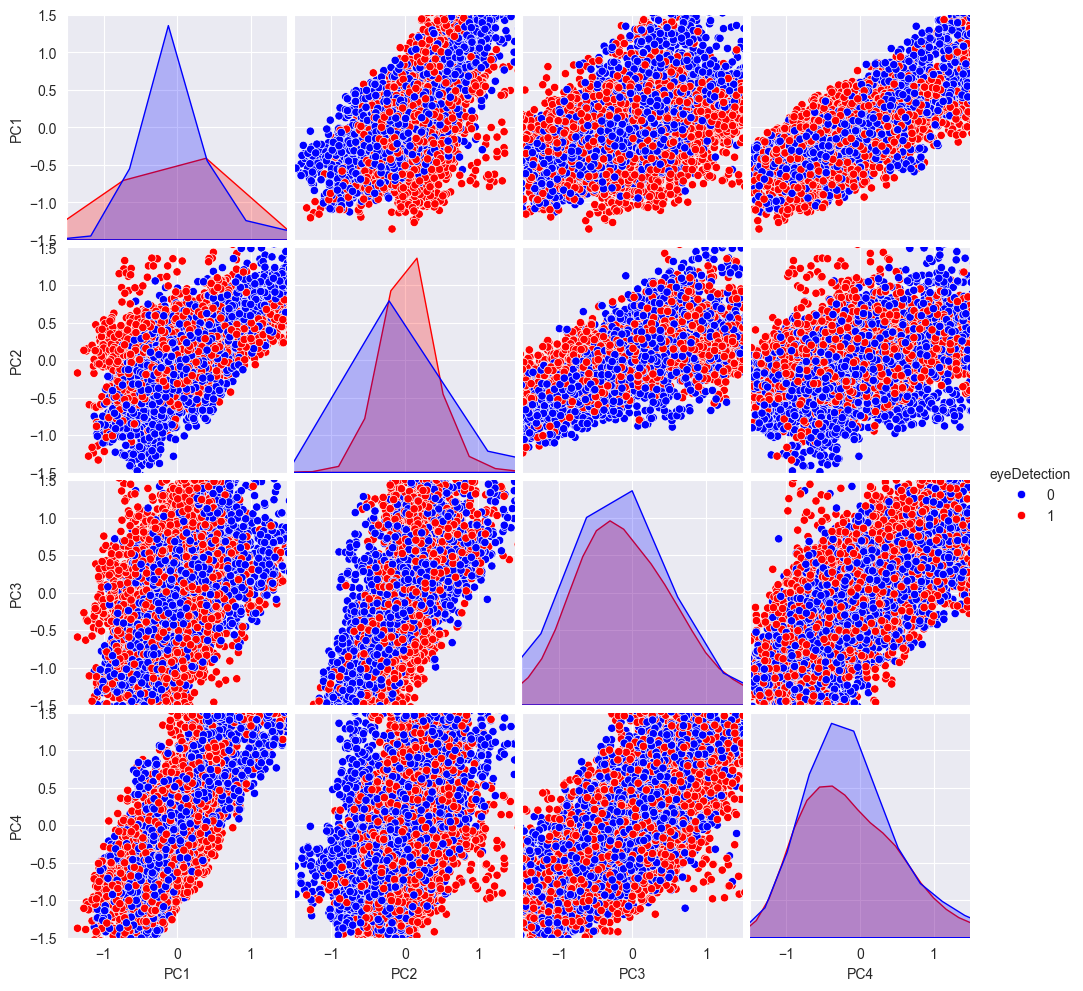

In [71]:
g = sns.pairplot(data=pca_df, hue='eyeDetection', palette={0: 'blue', 1: 'red'})

for ax in g.axes.flatten():
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
plt.show()

In [72]:
def accuracy(pred, y):
    correct = 0
    total = len(pred)
    for i, p in enumerate(pred):
        if p == y[i]:
            correct += 1
    return correct/total

### Hyperparameter tuning for k-nearest neighbours

- number of neighbours = [1, 2,..., 50]
- weights = [uniform, distance]

I chose metrics according to this article https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html

- metric = [minkowski (default), eucliean, manhattan]

I then use the sklearn GridSearchCV method to see which combination is the best for this problem. This method requires:
- An estimator: kNN
- A parameter grid
- Scoring: accuracy
- cv: 5
- verbose: 1

Outputs printed will be:
- best_params to see which parameters performed the best
- best_index to return the index of the best combination

At this point I noticed that I was getting suspiciously low test accuracy ($\approx$ 39%). The y_test array turned out to be extremely unbalanced, so I went back and changed it to stratify y.

In [80]:
knn_parameters = {
    'n_neighbors' : [i for i in range(1, 50)],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

knn = sk.neighbors.KNeighborsClassifier()

knn_param_search = sk.model_selection.GridSearchCV(estimator=knn,
                                                   param_grid=knn_parameters,
                                                   cv=5,
                                                   scoring='accuracy',
                                                   verbose=1)
knn_param_search.fit(X_pca_train, y_train)
print(f'kNN best parameters: {knn_param_search.best_params_}')
print(f'kNN index of best parameters: {knn_param_search.best_index_}')

knn_best = knn_param_search.best_estimator_
knn_test_pred = knn_best.predict(X_pca_test)
print(f'kNN test accuracy on best parameters: {accuracy(knn_test_pred, y_test):.2f}')

Fitting 5 folds for each of 196 candidates, totalling 980 fits
kNN best parameters: {'metric': 'euclidean', 'n_neighbors': 23, 'weights': 'distance'}
kNN index of best parameters: 45
kNN test accuracy on best parameters: 0.71


In [29]:
# todo come back to this
svm = sk.svm.SVC(kernel='rbf')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print(f'SVM test accuracy: {accuracy(svm_pred, y_test):.2f}')

SVM test accuracy: 0.09


In [34]:
clf = sk.ensemble.RandomForestClassifier(n_estimators=500)
clf.fit(X_train_scaled, y_train)
clf_predictions = clf.predict(X_test_scaled)
print(f'RandomForest test accuracy: {accuracy(clf_predictions, y_test):.2f}')

RandomForest test accuracy: 0.49


Low accuracies - decided to research smoothing techniques. Found moving average: choose a fixed window (increment by some step) and calculate the average over it, then train on that.

In [43]:
# 80/65
# 69% with label being first item in window
# 73% with label being last item in window
# 76% with label being middle item in window

def moving_average(X, y, window_size=80, step=65):
    i = 0
    X_w, y_w = [], []
    mid = window_size // 2

    while (i+window_size) <= X.shape[0]:
        w = X[i:i+window_size, :]
        means = w.mean(axis=0)
        label = int(y[i+mid])
        X_w.append(means)
        y_w.append(label)
        i += step
    return np.vstack(X_w), np.vstack(y_w).ravel()

X_train_smoothed, y_train_smoothed = moving_average(X_train_scaled, y_train)
X_test_smoothed, y_test_smoothed = moving_average(X_test_scaled, y_test)

model = sk.neighbors.KNeighborsClassifier(n_neighbors = 4)
model.fit(X_train_smoothed, y_train_smoothed)
smoothed_pred = model.predict(X_test_smoothed)
print(f'final test acc: {accuracy(smoothed_pred, y_test_smoothed):.4f}')

final test acc: 0.7556
